# Bicycle Rental Time Series Analysis

Bike sharing is a form of transportation in urban areas where passengers can get rent bikes from a number of public stations litered throughout a city for minutes or hours at a time and return them at any public station. Whether for leisurely riding or commuting throughout the city, bike sharing has been increasing in popularity worldwide over the past few decades- one of the main draws being how densely populated metro areas can frequently be navigated quicker by bike than by car. As a mix of engineering, logistics, and tech that has the potential to be a heavily utilized form of transportation in the future (due to the need for greener and more efficient modes of transportation for an increasing population), I think bike sharing is a particularly interesting subject of study.

Capital Bikeshare is one such bike sharing company in Washington DC that has stations available throughout the DMV area. They've made available their ridership data that goes all the way back to 2010, so there is a nice amount of data for messing around with (their data is available directly from their website here:
[Capital Bikeshare](https://www.capitalbikeshare.com/system-data)). I was personally interested in looking at how bike rental numbers have changed throughout the years and using time series modeling and analysis techniques to forecast how the ridership will continue to change in the future. 



## Data Aggregation and Transformation in PostgreSQL

Since the available data is quite rich (every single bike ride throughout the years is logged and included in the datasets), the total data set spanning back to 2011 takes up over 3gb. This brings up two caveats that needed to be addressed before proceeding in the analysis. First, I wanted to aggregate the daily data into overall monthly bike rental numbers 

Second, although this is still within the amount of RAM for almost all modern computers, this was a good opportunity to leverage SQL to do the data aggregation. SQL has good functionality for aggregating and transforming your data in order to get it into a form suitable for the analyses that you actually want to run- so in my case, I used a local PostgreSQL database to aggregate all of the individual bike rentals into overall monthly values. I used an SQL script to load the data in my database and aggregate them in batches (usually by a couple months at a time). For studies or applications with larger datasets that exceed the amount of RAM, processing the data in batches is one of the necessary work-arounds that must be considered. An example of one of the transactions is similar to the following snippet of SQL code:


``` postgresql
BEGIN;

create temporary table t 
(
  Duration NUMERIC,
  Start_time TIMESTAMP,
  End_time TIMESTAMP,
  Start_Station NUMERIC,
  Start_Station_Name VARCHAR,
  End_Station NUMERIC,
  End_Station_Name VARCHAR,
  Bike VARCHAR,
  Member VARCHAR 
);

COPY t 
FROM '/tmp/2013Q4-capitalbikeshare-tripdata.csv' DELIMITER ',' CSV HEADER;

INSERT INTO rides(Duration, Start, Bike, Member)
SELECT Duration, Start_time, Bike, Member
FROM t;

drop table t;

COMMIT;

```

<br>
I did not need all of the data available from Capital Bikeshare's datasets, so I eliminated unnecessary columns through the use of a temporary table. The entire set of data in each CSV file was imported into a temporary table, in which afterward I only copied over the relevant columns into a permanent table (called _rides_). Then the temporary table was dropped and this process was repeated until all relevant data was imported into my PostgreSQL database. After importing all of the data, aggregating the data to get the monthly ridership was a straight forward query:


``` PostgreSQL
SELECT DATE_TRUNC('month', start) AS Month, COUNT(bike) AS Num_Rides  
FROM rides
GROUP BY Month;
```

<br>
With the monthly ridership numbers, the total size of the dataset is something easily manageable within Python, so we can now move over to Python to do more indepth exploration and analysis of the data. For reference, the raw data from Capital Bikeshare was over 3gb, but the monthly aggregated dataset was no more than 2.3kb. I opted to save the aggregated data into a CSV file and load the CSV file in Python just to keep things simple and not have to bring in additional libraries for connecting Python to the PostgreSQL database.

For this project, I used _pandas_ for additional data manipulation and _statsmodels_ for time series modeling functionality. _pandas_ has become somewhat of a standard tool for data science and analysis tasks done with Python, and it has a useful _datetime_ data type for representing time series data that integrates well with statistical modeling libraries such as _statsmodels_. _matplotlib_ is needed for additional visualization and plotting purposes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX

We import two different api's from _statsmodels_: one for functionality to generate plots that we'll need to diagnose some of our models and the other for the actual models themselves. The models that we imported (_ExponentialSmoothing_ and _SARIMAX_) include Holt-Winters' method and the Seasonal ARIMA model. They were chosen specifically for their ability to handle the types of pattern and behavior found in the bike rental data- this will be further discussed in the following sections.

First, we'll need to read our data into a _pandas_ dataframe and make sure that the dataframe's index contains  the appropriate datetime values for each observation. Our aggregated data contains an observation for every month from 2013 to 2019, so we have 84 total values/rows in our data set. I always find it very useful to run the _head()_ method on my dataframes before diving into any exploratory data analysis or modeling just so I get a quick idea of the general structure of the data I am working with.

In [3]:
bike = pd.read_csv('./data/rides_monthly_aggregate.csv', usecols = [1])
bike.set_index(pd.period_range('1/1/2013', freq='M', periods=84), inplace = True)

bike.head()

,num_rides
2013-01,124989
2013-02,110102
2013-03,157366
2013-04,236442
2013-05,250463


## Exploratory Data Analysis

We begin by plotting our time series data. With time series data, a lot of the patterns and properties that we are interested in can generally be seen by simplying plotting the data itself. Plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) also aid in identifying these same patterns and properties. The ACF displays the correlation between our time series data and lagged version of itself. The PACF is similar to the ACF, but partial autocorrelation is a value that is adjusted to remove the effects from all lags save for the one we are interested in (e.g. the partial autocorrelation between the data and lag-3 data is adjusted to remove any effects from lag-1 and lag-2 on the correlation value).

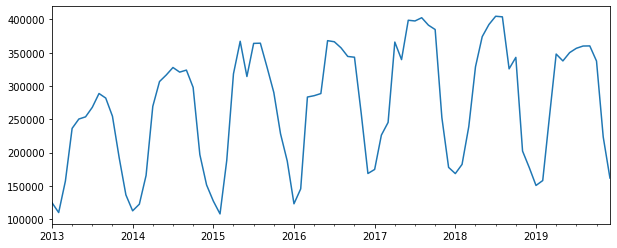

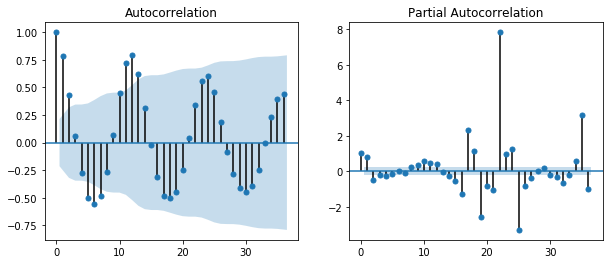

In [4]:
bike['num_rides'].plot(figsize = (10,4));

fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig = sm.graphics.tsa.plot_acf(bike['num_rides'], lags=36, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bike['num_rides'], lags=36, ax=axes[1])

<br>

From the plot of the time series data alone, we see strong seasonal behavior and a very mild upward trend that tapers off at the end. This is further supported by the ACF plot with the decreasing sinusoidal behavior of the ACF values. 

From the data, we see a general seasonal behavior of bike rental numbers increasing in the middle of the year and decreasing towards the end of the year. This behavior does seem intuitive as the summer months in Washington DC have much more favorable weather conditions for outdoor activities than the winter months. Additionally, summer time in the United States is coincides with increased tourism as schools and universities are on summer breaks. These are potential reasons that contribute to the seasonal behavior that we see. With regards to trend, we do see a slight upward trend over the years, with a tapering off at the end. This possibly points towards a gradual increase in the adoption of bike sharing for commuting or leisure purposes.

## Model Fitting

With seasonality and trend identified in our data, we need to be conscious of choosing time series models that can handle trend and seasonality so that these patterns are reflected in our models' forecasts. Exponential Smoothing and ARIMA models are two of the most widely used types of time series models that we will also use for our modeling purposes. They both can handle seasonality and trend in data and provide for very accurate forecasts, although the models work in notably different ways. 

### Exponential Smoothing (Holt-Winter's Method)

We'll first try Holt-Winter's method for modeling out data. Exponential Smoothing methods essentially use weighted averages of the observed data in order to fit a model that can accurate model the patterns found in the data, where the weights exponentially decrease for observations that are further in the past. Additional component (essentially equations) are added to the model to capture trend and seasonality within the data.

We use Holt-Winter's method with both additive trend and seasonality along with dampening to model the data. We then set _seasonal_periods_ to be 12 in order to capture the monthly seasonality that occurs every year. We fit the model and plot the model's fitted values over the true data in the following:

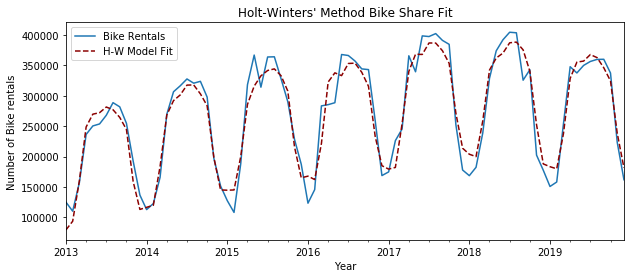

In [5]:
fit_hw = ExponentialSmoothing(bike, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()

bike_plot = bike.plot(figsize=(10,4), title="Holt-Winters' Method Bike Share Fit")
bike_plot.set_ylabel("Number of Bike rentals")
bike_plot.set_xlabel("Year")

fit_hw.fittedvalues.plot(ax=bike_plot, style='--', color='DarkRed')
bike_plot.legend(['Bike Rentals', 'H-W Model Fit']);

In [6]:
# The MAPE (Mean Average Percentage Error) of the H-W model
np.average(np.absolute((fit_hw.fittedvalues - bike['num_rides']) / bike['num_rides']))

0.08627115348980559

<br>

Our model does seem to capture the seasonality and overall increasing trend well- even capturing the slight tapering off and decrease within year 2019. 

As a good measure of how well the model fits the data, we take a look at the Mean Average Percentage Error (MAPE) of the model, which provides how "off" our model's fitted values are from the true data in percentage. Given above, our model's fitted values are off by an average of 8.6% of the true observations, which is pretty accurate. We could use the MAPE for model selection if we had a number of models to compare each other against in order to select the optimal model, but since we only have one model, the MAPE value is useful for seeing how well our model fits the data. The low MAPE value gives us confidence that our model fits the data well and is capturing information that will generate useful forecasts.

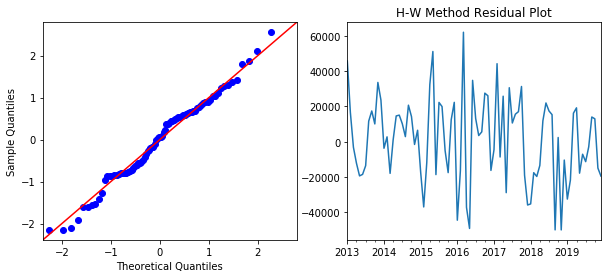

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Using the 
fig = sm.qqplot(fit_hw.resid, line='45', fit=True, ax=axes[0])
fig = fit_hw.resid.plot(title="H-W Method Residual Plot", ax=axes[1]);

<br>

Before proceeding with using our model for forecasting purposes, we ran diagnostic measures to ensure that our model fit is strong as well as check to see if there is any additional information left in the residuals/errors that we can further extract to improve the model. 

For diagnosing our model and checking model assumptions, we utilized a quantile-quantile (QQ) plot and a time plot of the residuals. On the left, we have the QQ plot with a normal distribution plotted on the diagonal. The observations follow the diagonal closely, albeit with some fluctuations from strict normal distribution towards the tails, so we can conclude that it is reasonable to assume the residuals are of normal distribution. On the right, we have a time plot of the residuals. There are no obvious visual patterns or behavior in this plot, so we conclude that the residuals are not correlated and that most of the information in our data has been extracted for model fitting. With these two things checked, we proceed with using our model for a forecast. 


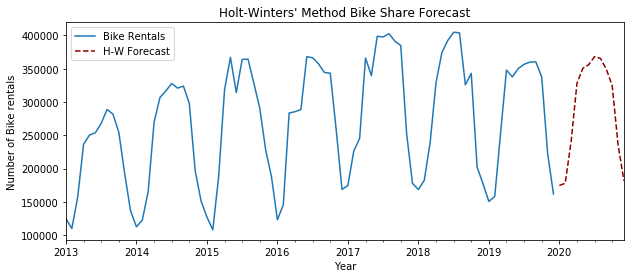

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
fig = bike['num_rides'].plot(ax=ax, title="Holt-Winters' Method Bike Share Forecast")
fig.set_ylabel("Number of Bike rentals")
fig.set_xlabel("Year")
fit_hw.forecast(12).plot(ax = ax,style = '--', color = 'DarkRed')
fig.legend(['Bike Rentals', 'H-W Forecast']);

<br>

We see that the Holt-Winters' method predicts the 2020 year to have monthly average riderships that reflect pretty much the same seasonal pattern that we've seen in prior years. Note that the forecasted months reflect this lowered ridership count, which follows the downward trend that occured from 2018 to the end of 2019. Note that there forecasts come with no associated prediction intervals when using the Holt-Winters' method since it technically is not a statistical model, so our forecasted values are only point forecasts. _statsmodels_ does have an equivalent statespace model to the Holt-Winters' method that allows for accompanying prediction intervals for the forecasts, so if you are interested, you can check them out here: [link](https://www.statsmodels.org/stable/statespace.html#linear-exponential-smoothing-models).

In particular, the predicted monthly bike rental numbers for 2020 are given in the following output. Note that the numbers returned are decimal values representing the forecasted mean number of rentals at each month (otherwise it wouldn't make sense to predict that we'll have a fraction of a rental).

In [9]:
fit_hw.forecast(12)

2020-01    174730.700724
2020-02    178107.232711
2020-03    240402.581126
2020-04    328052.273252
2020-05    350640.580571
2020-06    356054.444794
2020-07    368189.065083
2020-08    365507.146899
2020-09    349329.192789
2020-10    324623.206408
2020-11    235689.084023
2020-12    181698.275617
Freq: M, dtype: float64

### Seasonal ARIMA 

Our second model is the Seasonal ARIMA model (sometimes abbreviated as SARIMA), which is one of the most widely used time series modeling methods along with Holt-Winters' method. ARIMA models mainly use information from the autocorrelation in the time series data for modeling and forecasting purposes- the idea being that if future values of a variable are be strongly correlated with its past values, then knowing the past values should allow you to make good predictions. The Seasonal ARIMA usually is denoted as _ARIMA(p,d,q)(P,D,Q)m_ where each one of _p, d, q, P, D,_ and _Q_ denotes a different parameter within the model. Before fitting a model, we must determine appropriate values for each of them via a number of methods.

First, we must determine _d_ and _D_ by considering if our data is stationary, and if not, what type of differencing must we apply in order to get stationary data. Given the strong seasonality that we've already identified in our data, we start with seasonally differencing our data to see if it can produce stationary data:

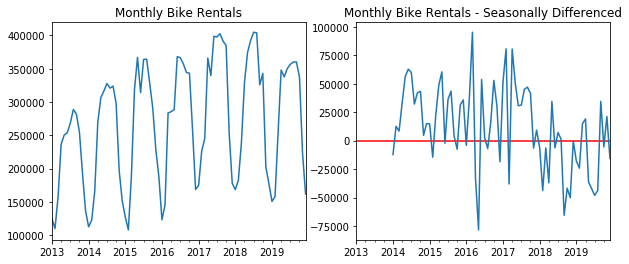

In [14]:
bike['seasonal_diff'] = bike.diff(periods = 12)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig = bike['num_rides'].plot(ax = axes[0], title = "Monthly Bike Rentals")
fig = bike['seasonal_diff'].plot(ax = axes[1], title = "Monthly Bike Rentals - Seasonally Differenced")
axes[1].hlines(0, bike.index[0], bike.index[-1], 'r');

<br>

Above, the plot of the bike rental data is given on the left, while the seasonally differenced data is given on the right. Visually, it seems like seasonal differencing has done well in making our data stationary, so we'll proceed with the ARIMA modeling with a single application of seasonal differencing, so we'll set _d = 0_ and _D = 1_ for our model.

For determining suitable values for _p, q, P,_ and _Q_, we will need to look at the ACF and PACF plots of the seasonally differenced data:

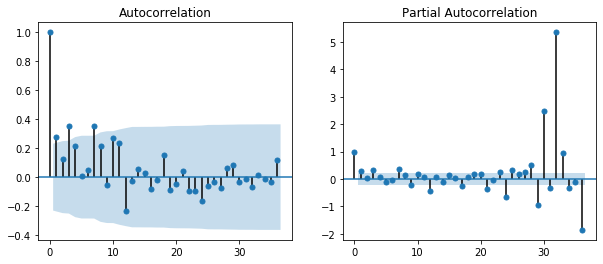

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig = sm.graphics.tsa.plot_acf(bike['seasonal_diff'].iloc[12:], lags=36, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bike['seasonal_diff'].iloc[12:], lags=36, ax=axes[1]);

In [17]:
sarima_models = pd.DataFrame(np.zeros((3,2), dtype=float))
for p in range(3):
    for q in range(2):
        fit_sarima = SARIMAX(bike['num_rides'], order = (p,0,q), seasonal_order=(1,1,0,12)).fit()

        try:
            sarima_models.iloc[p,q] = fit_sarima.aicc
        except:
            sarima_models.iloc[p,q] = np.nan

sarima_models

,0,1
0,1722.721495,1722.403702
1,1722.460652,1716.695980
2,1724.634698,1724.740077


In [18]:
# The model with the lowest AICc had p = q = 1, so we fit an ARIMA(1,0,1)(1,1,0)12 model
fit_sarima = SARIMAX(bike['num_rides'], order = (1,0,1), seasonal_order=(1,1,0,12)).fit()

fit_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           num_rides   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -854.049
Date:                             Sun, 19 Apr 2020   AIC                           1716.099
Time:                                     22:51:55   BIC                           1725.206
Sample:                                 01-31-2013   HQIC                          1719.724
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9609      0.019     50.131      0.000       0.923       0.998
ma.L1         -0.9350      0.032    -29.509      0.000      -0.997      -0.873
ar.S.L12      -0.0722      0.089     -0.809      0.418      -0.247       0.103
sigma2      1.303e+09    6.9e-12   1.89e+20      0.000     1.3e+09     1.3e+09
===================================================================================
Ljung-Box (Q):                       56.79   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.04   Prob(JB):                         0.81
Heteroskedasticity (H):               1.47   Skew:                            -0.05
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.85e+35. Standard errors may be unstable.
"""

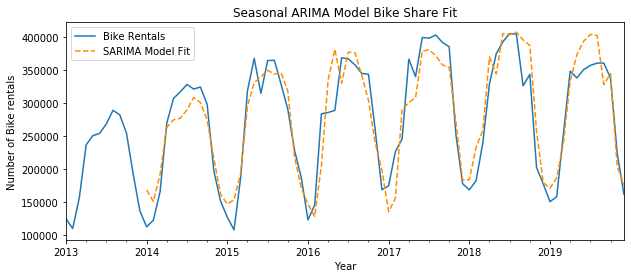

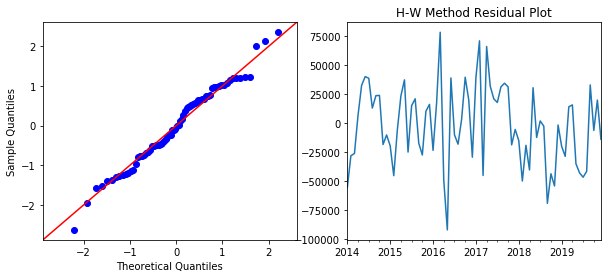

In [23]:
bike_plot = bike['num_rides'].plot(figsize = (10,4), title = "Seasonal ARIMA Model Bike Share Fit")
bike_plot.set_ylabel("Number of Bike rentals")
bike_plot.set_xlabel("Year")

fit_sarima.fittedvalues.iloc[12:].plot(ax = bike_plot, style = '--', color = 'DarkOrange')
bike_plot.legend(['Bike Rentals', 'SARIMA Model Fit'])

fig, axes = plt.subplots(1, 2, figsize=(10,4))

fig = sm.qqplot(fit_sarima.resid.iloc[12:], line='45', fit=True, ax=axes[0])
fig = fit_sarima.resid.iloc[12:].plot(title="H-W Method Residual Plot", ax=axes[1]);